# **Predictive Analysis of Academic Performance Utilizing Study Habits and Prior Achievement Metrics**

In [1]:
# libraries needed in this proposal

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## **Introduction**

#### **Relevant background information on the topic**

The advent of the digital era and web-based learning systems has transformed education, allowing for an intricate study of student engagement. Our research, grounded in Kahraman et al.'s dataset (2013), capitalizes on these advancements by examining diverse behavioral variables.

#### **The Question we will try to answer with our project**

Our research seeks to employ this dataset to answer two key questions: First, can we predict a student's knowledge level (UNS) based on study time for material (STG), repetition number for material (SCG), study time for related objects or prerequisites (STR), exam performance for related objects (LPR), and exam performance for material (PEG)? Second, utilizing STG, SCG, STR, and LPR, which factor correlates most strongly with PEG, the exam performance for material?

#### **The dataset description that will be used to answer the question**

The core of our study are two CSV datasets: training and testing. Containing 258 and 145 entries respectively, these datasets include variables representing study time (STG), repetition number (SCG), study time for related objects (STR), exam performance for related objects (LPR), material exam performance (PEG), and user knowledge level (UNS). These resources will guide our exploration into the determinants of academic performance in a digital learning context.

## **Preliminary exploratory data analysis**

#### **Data Acquisition**

In [2]:
# download data from our group's remote repository

url <- "https://raw.githubusercontent.com/stankur/dsci-100-project/main/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv"

data <- read_csv(url)

data <- data |> 
        select(STG:UNS)

data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


#### **Initial Data Summary (Exploratory Data Analysis)**

In [3]:
# Mean values of quantitative variables
mean_data <- data |>
                mutate(STG = mean(STG),  
                       SCG = mean(SCG), 
                       STR = mean(STR),
                       LPR = mean(LPR),
                       PEG = mean(PEG)) |>
                select(STG, SCG, STR, LPR, PEG) |>
                head(1)

# Checking for missing data
na <- data |> 
            mutate(STG = is.na(STG), SCG = is.na(SCG), 
                   STR = is.na(STR), LPR = is.na(LPR), 
                   PEG = is.na(PEG), UNS = is.na(UNS)) |>
            select(STG, SCG, STR, LPR, PEG, UNS) |>
            head(1)

# Summary of 'UNS' categorical variable
uns_grouped_by_level <- group_by(data, UNS) |>
                        summarize(count = n())

# Transforming data for reporting
mean_tidy <- mean_data |>
        pivot_longer(cols = STG:PEG,
                    names_to = "Feature", values_to = "Mean") 

na_tidy <- na |>
        pivot_longer(na, cols = STG:UNS,
                    names_to = "Feature", values_to = "NA")

tidy <- data.frame("Feature" = c("STG", "SCG", "STR", "LPR", "PEG", "UNS"),
                   "Mean" = c(0.3711473, 0.3556744, 0.4680039, 0.4327132, 0.4585388, "NA"),
                   "Is.NA" = c(FALSE, FALSE, FALSE, FALSE, FALSE, FALSE)) |>
        as_tibble(tidy)

tidy
uns_grouped_by_level

Warning message in gsub(vec_paste0("^", names_prefix), "", cols):
“argument 'pattern' has length > 1 and only the first element will be used”


Feature,Mean,Is.NA
<chr>,<chr>,<lgl>
STG,0.3711473,FALSE
SCG,0.3556744,FALSE
STR,0.4680039,FALSE
LPR,0.4327132,FALSE
PEG,0.4585388,FALSE
UNS,NA,FALSE


UNS,count
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


#### **Data Visualization**

Our initial visualization consists of histograms illustrating the distribution of numerical variables (STG, SCG, STR, LPR, PEG), effectively revealing their range and frequency. Following this, we present a bar chart showcasing the distribution of categorical variable UNS (knowledge level), enabling a comparative analysis of each knowledge level category's frequency.

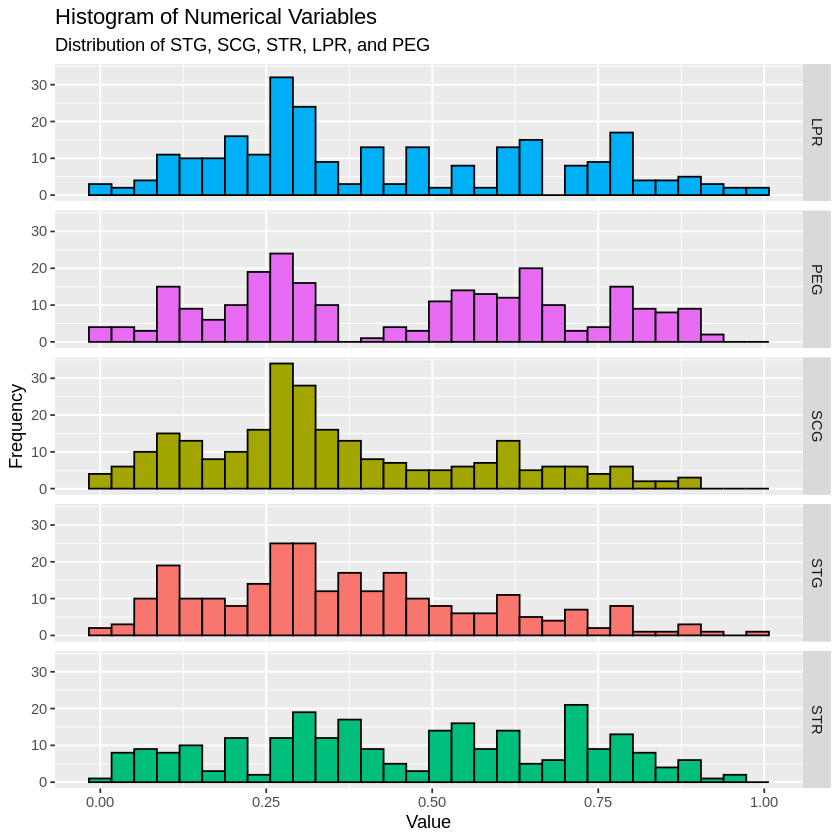

In [4]:
# Selecting numerical columns for visualization
histogrammable_data <- data |> select(STG:PEG)

# Reshaping the data from wide format to long format to facilitate visualization
histogrammable_data_pivoted <- pivot_longer(histogrammable_data, 
                                           cols= STG:PEG,
                                           names_to = "column_name",
                                           values_to ="value")

# Creating a histogram for each numerical variable
quantitative_plot <- ggplot(histogrammable_data_pivoted, aes(x = value, fill = as_factor(column_name))) +
        geom_histogram(bins = 30, color = "black") + 
        facet_grid(rows = vars(column_name)) +  
        labs(fill = "Variable", x = "Value", y = "Frequency", 
             title = "Histogram of Numerical Variables", 
             subtitle = "Distribution of STG, SCG, STR, LPR, and PEG") +
        theme(legend.position = "none") 

quantitative_plot

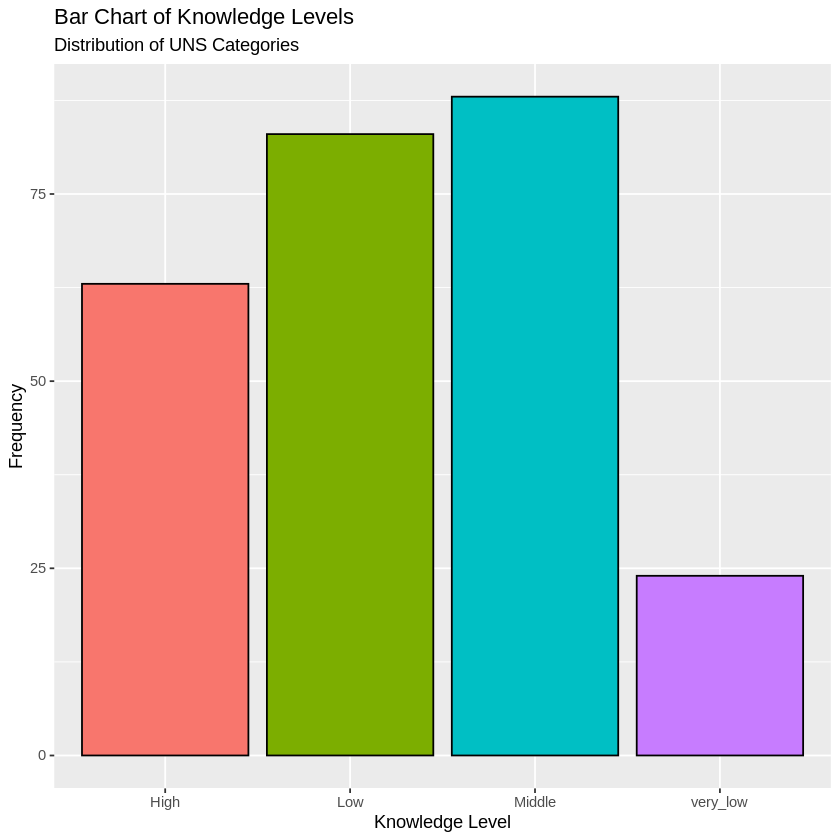

In [5]:
# Organize categories in descending order
uns_grouped_by_level <- uns_grouped_by_level |> 
                        mutate(UNS = factor(UNS, levels = names(sort(table(UNS), decreasing = TRUE))))

# Create bar chart for the categorical variable 'UNS'
uns_bar <- ggplot(uns_grouped_by_level, aes(x=UNS, y=count, fill=UNS)) + 
        geom_bar(stat="identity", color="black") + 
        labs(x="Knowledge Level", 
             y="Frequency", 
             title = "Bar Chart of Knowledge Levels", 
             subtitle = "Distribution of UNS Categories", 
             fill="Knowledge Level") +
        theme(legend.position = "none")

uns_bar

## **Methods**

#### **Data Analysis Plan and Chosen Variables**

To predict the 'UNS' (User Knowledge Level), we'll adopt a systematic approach, beginning with calculating pairwise correlation of all dataset variables. This will guide us in employing appropriate variables in a k-nearest neighbors model for 'UNS' prediction. We'll further apply a linear regression model using 'STG', 'STR', and 'LPR' to predict 'PEG', focusing on the strongest 'PEG' predictors.

#### **Visualization of Results**

For an intuitive visualization of our findings, we'll leverage the 'ggpairs' function from the 'GGally' R package. This will enable a scatterplot matrix construction, offering a detailed insight into variable relationships and interactions.

## **Expected Outcomes and Significance**

#### **Expected Findings**

We hypothesize that the variables we have chosen for our models significantly influence the user knowledge level, and consequently, anticipate that our predictive model will have a high degree of accuracy. Moreover, we postulate that the 'LPR' variable, representing the repetition number for the material, will exhibit the most potent influence on exam performance, represented by the 'PEG' variable.

#### **Implications of Findings**

The implications of our anticipated findings are multifold. Primarily, they can guide the development of effective study strategies for students. For instance, if a strong relationship is observed between 'LPR' and 'PEG', it could recommend an emphasis on repetitive learning of basic subject material.

#### **Future Research Questions**

Our study could pave the way for several interesting research questions, including:

- How can the web learning system be optimized to promote superior knowledge growth among users?
- Which metrics (e.g., repetition or study time) should be emphasized for improved learning outcomes?
- Which type of study material (e.g., goal-oriented or related materials) holds the most promise for academic achievement?


## **Reference**

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283-295. https://doi.org/10.1016/j.knosys.2012.08.009
